In [1]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from prob2utils_YM import train_model, get_err

%matplotlib inline

ratings = pd.read_csv(os.path.join('data', 'data.txt'), sep='\t', header=None, names=['User ID', 'Movie ID', 'Rating'])

# Read in information on movies
names = ['Movie ID', 'Movie Title', 'Unknown', 'Action',
         'Adventure', 'Animation', 'Children\'s', 'Comedy',
         'Crime', 'Documentary', 'Drama', 'Fantasy',
         'Film-Noir', 'Horror', 'Musical', 'Mystery',
         'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(os.path.join('data', 'movies.txt'), sep='\t', header=None, encoding='latin_1', names=names)
movies['Movie Title'] = movies['Movie Title'].str.strip()

savefig_kwargs = {'dpi': 200, 'bbox_inches': 'tight', 'transparent': True}
plt.rc('pdf', fonttype=42)
#%config InlineBackend.figure_format = 'pdf'
%config InlineBackend.print_figure_kwargs = savefig_kwargs

In [2]:
# Separate movie name and year if desired
split_year = False
if split_year:
    movies.loc[266, 'Movie Title'] = 'unknown (0000)'
    movies.loc[1411, 'Movie Title'] = \
        'Land Before Time III: The Time of the Great Giving (V) (1995)'
    movies['Year'] = [int(title[-5:-1]) for title in movies['Movie Title']]
    movies['Movie Title'] = [title[:-7] for title in movies['Movie Title']]

In [3]:
# Merge ratings data with movie metadata
pdData = ratings.merge(movies, how='left', on='Movie ID')
data = np.random.permutation(pdData)

In [4]:
totRate = np.zeros(len(movies))
numRate = np.zeros(len(movies))
for y in data:
    totRate[y[1] - 1] += y[2]
    numRate[y[1] - 1] += 1
    
avgRate = totRate/numRate

rMovies = movies
rMovies['Average Rating'] = avgRate

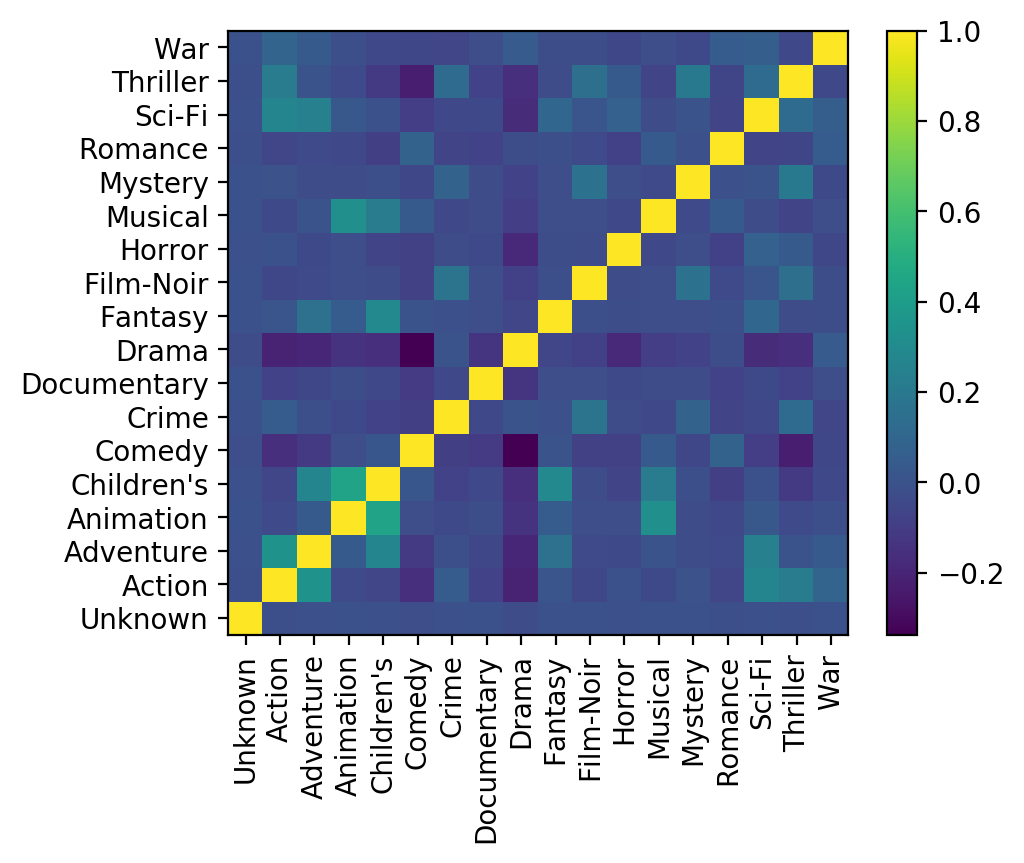

In [24]:
genreCorr = np.corrcoef(np.array(movies.iloc[:, 2:-2]).T)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
heatmap = ax.pcolor(genreCorr)
ax.set_yticks(np.arange(genreCorr.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(genreCorr.shape[1]) + 0.5, minor=False)

ax.set_xticklabels(movies.columns[2:-2], minor=False, rotation=90)
ax.set_yticklabels(movies.columns[2:-2], minor=False)

fig.colorbar(heatmap)

plt.show()

In [5]:
trainData = data[0: 90000]
testData = data[90000:]

In [6]:
M = max(max(trainData[:,0]), max(testData[:,0])) # users
N = max(max(trainData[:,1]), max(testData[:,1])) # movies
print("Factorizing with ", M, " users, ", N, " movies.")


Factorizing with  943  users,  1682  movies.


In [26]:
K = 20
U, V, loss = train_model(M, N, K, 0.03, 0.32, trainData[:, 0:3], eps=1e-10, max_epochs=300)
print('Testing error is: {0:.2f}'.format(get_err(U, V, testData[:, 0:3])))

early stop at 2
Testing error is: 1.09


In [27]:
u, s, vh = np.linalg.svd(V)
rotV = V @ vh.T
print(s)

[72.79232005  8.1312956   8.02472951  7.90715232  7.73613324  7.65423919
  7.52798527  7.35911634  7.33090073  7.2933885   7.2132727   7.06730368
  7.0048097   6.86079014  6.75191154  6.66148105  6.59135474  6.58407584
  6.5225773   6.10339381]


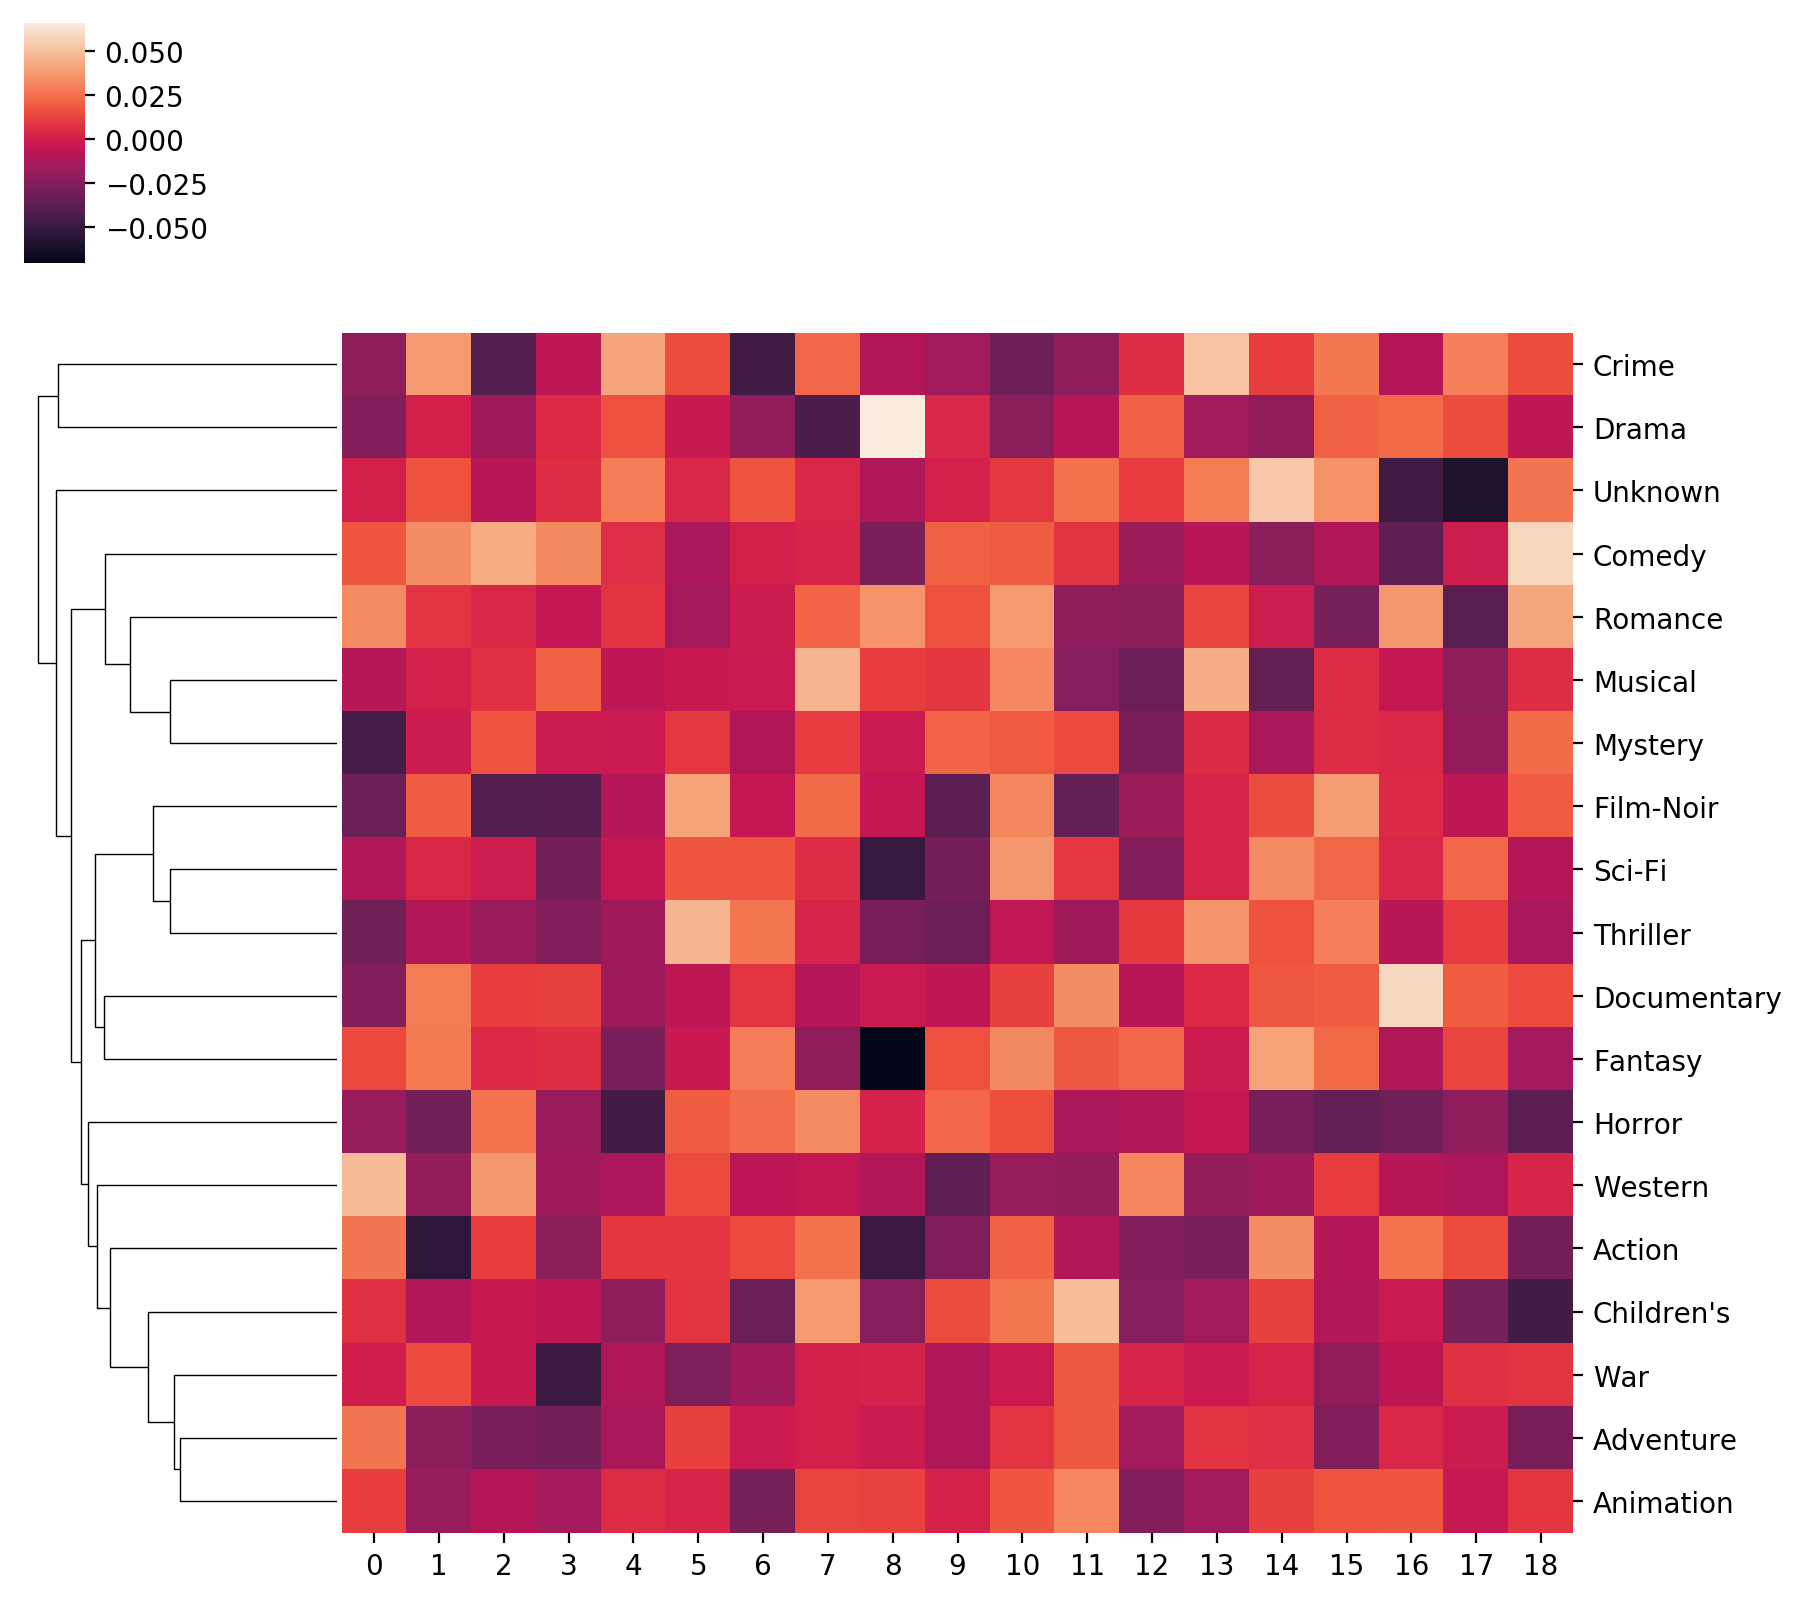

In [28]:
genres = movies.columns[2:-1]
coefs = np.zeros((len(genres), rotV[:, 1:].shape[1]))

for i in range(len(genres)):
    for j in range(rotV[:, 1:].shape[1]):
        coef = np.corrcoef(np.array(movies.iloc[:, i + 2]), rotV[:, j + 1])[0, 1]
        coefs[i, j] = coef

pdCoefs = pd.DataFrame(coefs, index=genres)
sns.clustermap(pdCoefs, col_cluster=False, method='average')

Text(0.5, 68.99999999999991, 'Factor #')

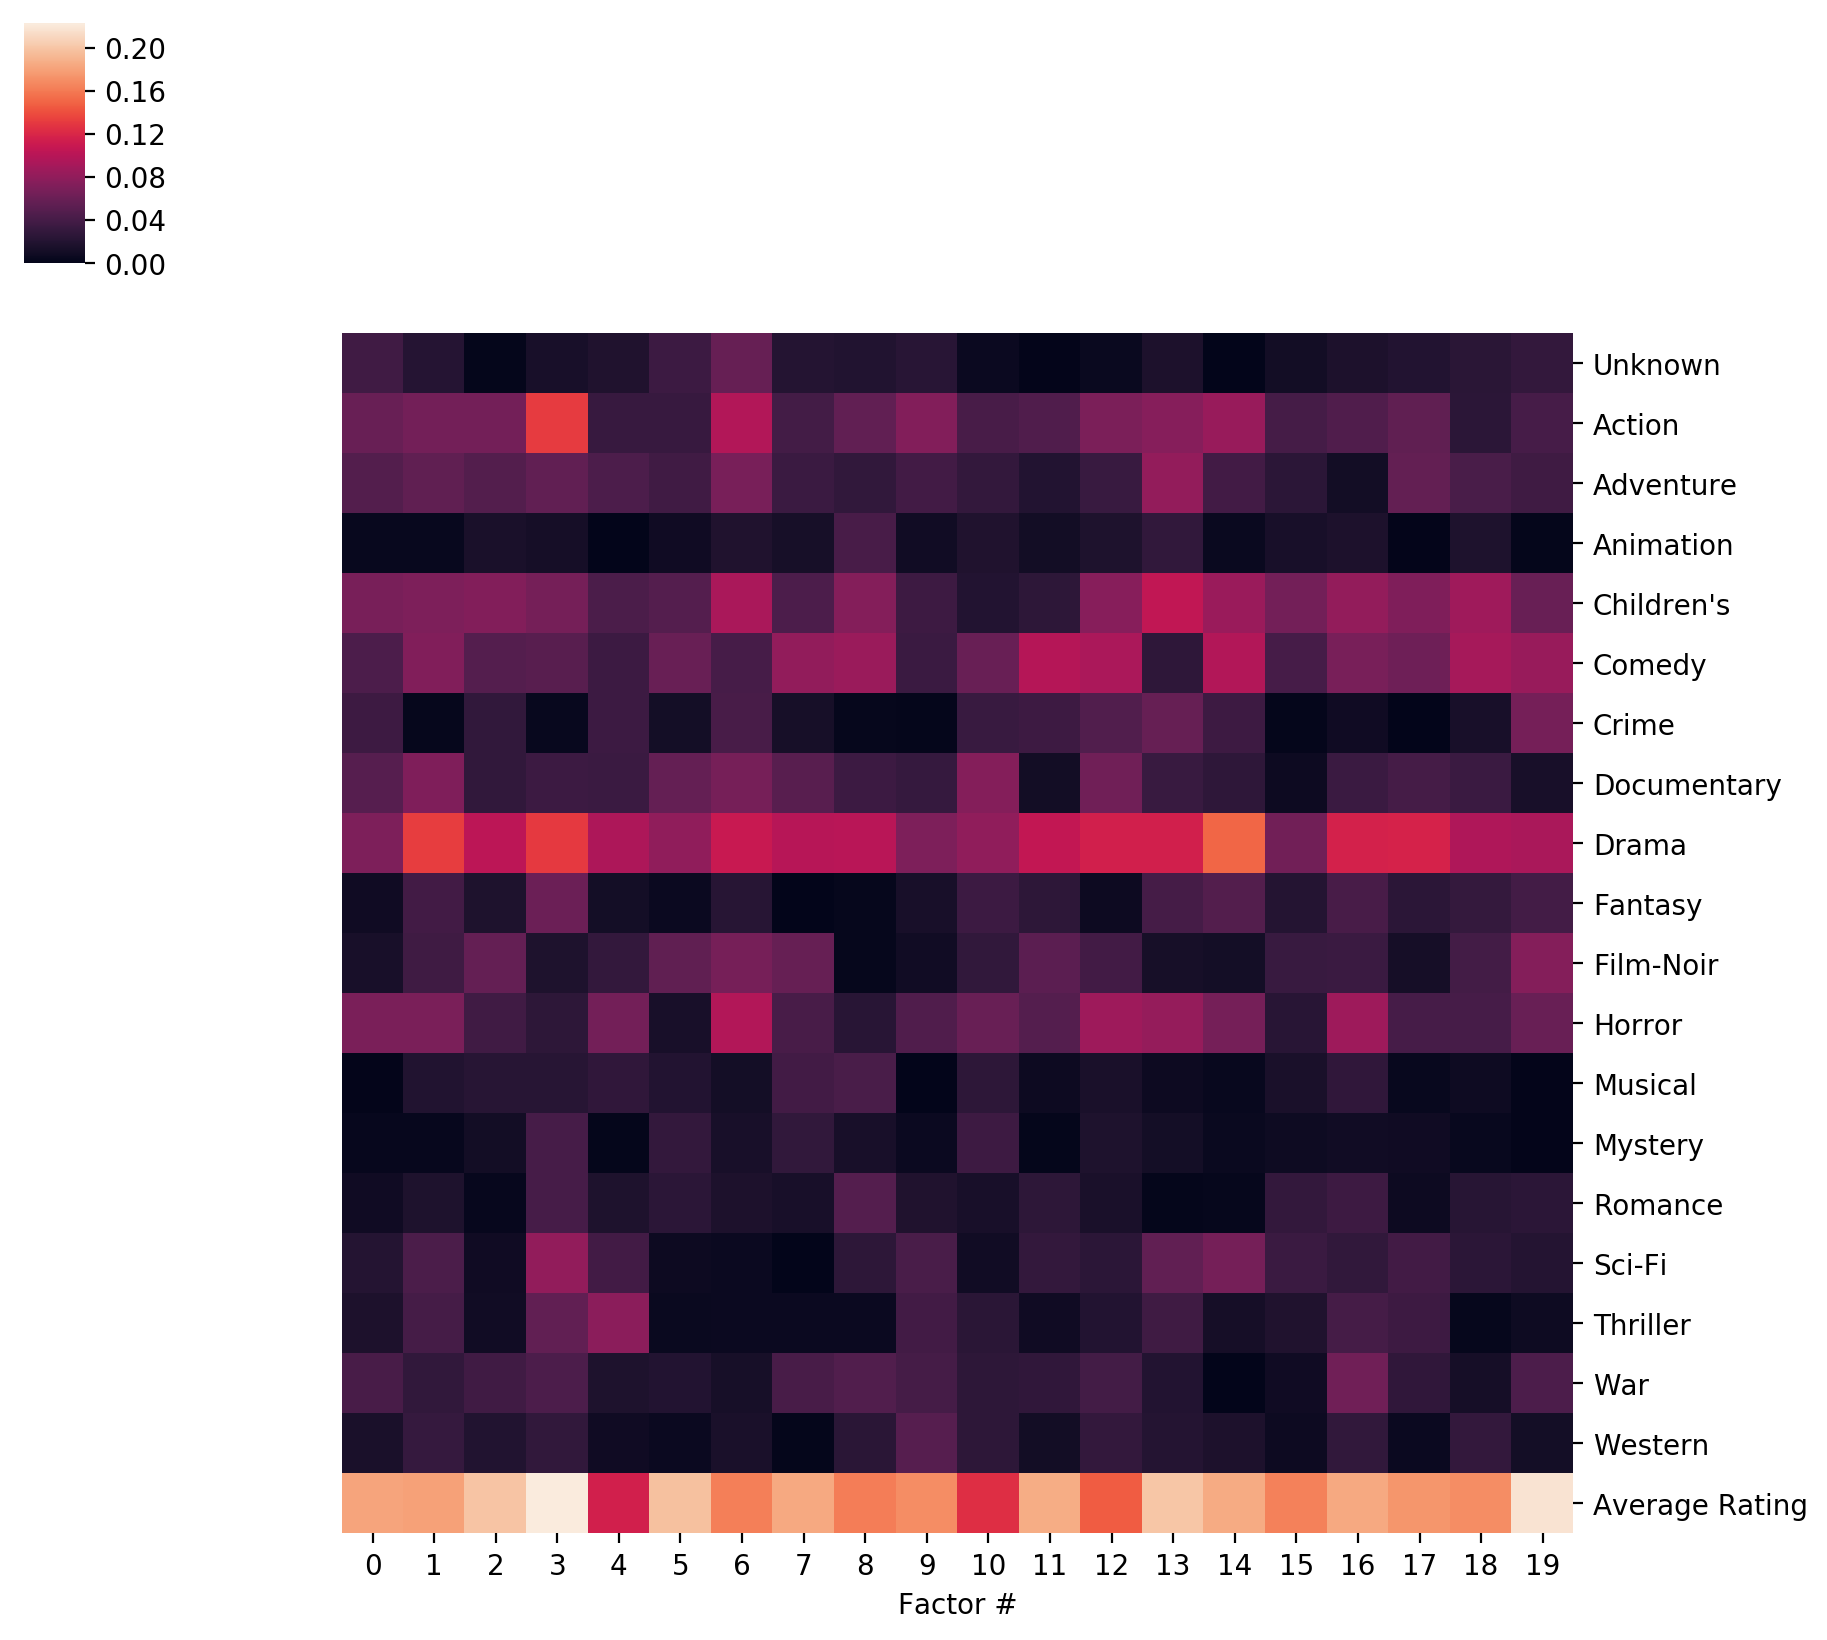

In [40]:
genres = movies.columns[2:]
coefs = np.zeros((len(genres), V.shape[1]))

for i in range(len(genres)):
    for j in range( V.shape[1]):
        coef = np.corrcoef(np.array(movies.iloc[:, i + 2]), V[:, j])[0, 1]
        coefs[i, j] = coef

pdCoefs = pd.DataFrame(np.abs(coefs), index=genres)
cm = sns.clustermap(pdCoefs, col_cluster=False, row_cluster=False, method='average')
cm.ax_heatmap.set_xlabel('Factor #')

In [39]:
# plt.set_xlabel(cm.ax_heatmap, 'Factor #')
cm.ax_heatmap.set_xlabel('Factor #')

Text(0.5, 8.888888888888875, 'Factor #')

Text(0, 0.5, 'Movie average rating')

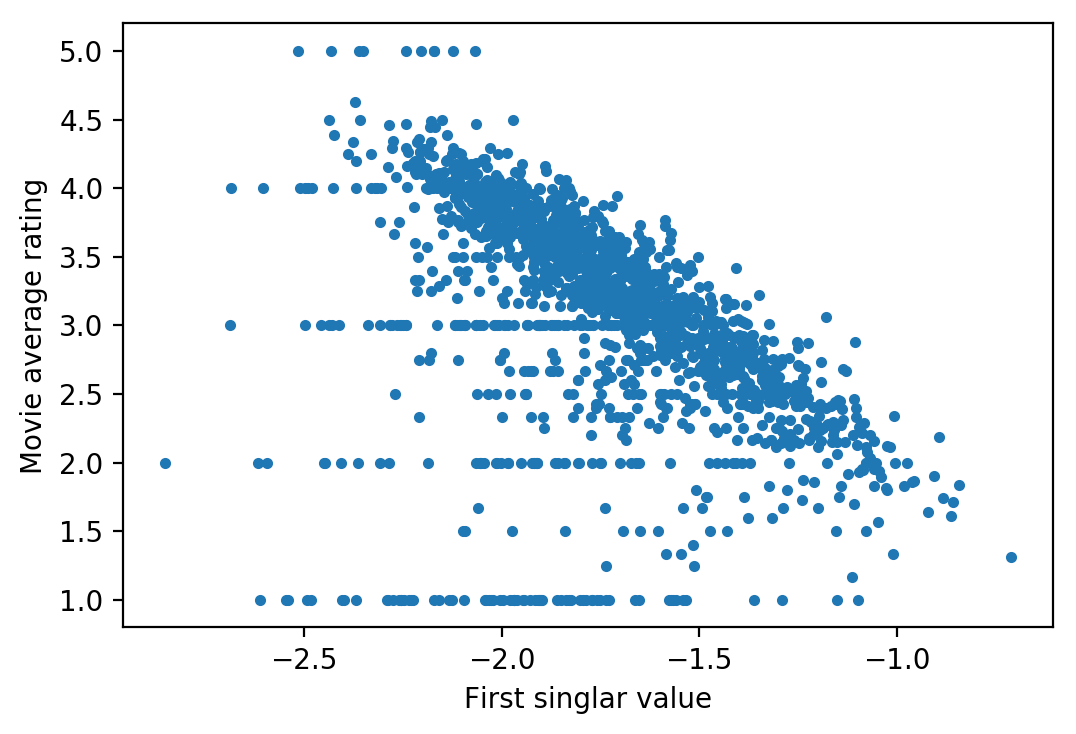

In [30]:
plt.plot(rotV[:,0], rMovies['Average Rating'], '.')
plt.xlabel('First singlar value')
plt.ylabel('Movie average rating')

In [226]:
reduce

(19, 19)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

